In [1]:
import numpy as np
import pandas as pd
import json
import os

from matplotlib import pyplot as plt
from glob import glob
from sklearn.metrics import roc_auc_score

from code_base.utils import load_json
from code_base.utils.metrics import score_numpy

/backup/vova/src/exps/bird_clef_2024/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# GT Data

In [2]:
df = pd.read_csv(
    "/home/vova/data/exps/birdclef_2024/birdclef_2024/train_metadata_extended_noduplv1.csv"
)
split = np.load(
    "/home/vova/data/exps/birdclef_2024/cv_splits/birdclef_2024_5_folds_split_nodupl.npy",
    allow_pickle=True
)
val_df = [df.iloc[split[i][1]].reset_index(drop=True) for i in range(len(split))]

bird2id = load_json(
    "/home/vova/data/exps/birdclef_2024/class_mappings/bird2int_2024.json"
)
scored_birds = load_json("/home/vova/data/exps/birdclef_2024/scored_birds/sb_2024.json")
id2bird = {v:k for k,v in bird2id.items()}

# Predicted Data

In [11]:
## IMPORTANT!!!
# print("Extracting scored_bird_ids indices")
# scored_bird = load_json(CONFIG["scored_birds_path"])
# scored_bird_ids = [bird2id[el] for el in scored_bird]
# val_tgts = [el[:,scored_bird_ids] for el in val_tgts]
# val_preds = [el[:,scored_bird_ids] for el in val_preds]

In [3]:
predictions = glob("../predictions/*")
predictions = {
    os.path.basename(el): {
        "gt": np.load(os.path.join(el, "tgts.npy"), allow_pickle=True),
        "pred": np.load(os.path.join(el, "preds.npy"), allow_pickle=True),
    }
    for el in predictions
}

In [4]:
print("\n".join([el for el in predictions.keys()]))

eca_nfnet_l0_Exp_noamp_64bs_5sec_PrevCompXCScoredDataNoSecLab_TimeFlip05_FormixupAlpha05_AdamW_wd1e6_lr1e5_1e4_0_WarmCosEpoch_Epoch50_SpecAugV207_FocalBCELoss_5Folds_NoDuplsV1
eca_nfnet_l0_Exp_noamp_64bs_5sec_TimeFlip05_FormixupAlpha05_AdamW_wd1e6_lr1e5_1e4_0_WarmCosEpoch_Epoch50_SpecAugV207_FocalBCELoss_5Folds_NoDuplsV1
eca_nfnet_l0_Exp_noamp_64bs_5sec_PrevCompXCScoredDataNoSecLab_TimeFlip05_FormixupAlpha05_balSampl_AdamW_wd1e6_lr1e5_1e4_0_WarmCosEpoch_Epoch50_SpecAugV207_FocalBCELoss_5Folds_NoDuplsV1
eca_nfnet_l0_Exp_noamp_64bs_5sec_PrevCompXCScoredDataNoSecLab_TimeFlip05_FormixupAlpha05_balSamplas2024_AdamW_wd1e6_lr1e5_1e4_0_WarmCosEpoch_Epoch50_SpecAugV207_FocalBCELoss_5Folds_NoDuplsV1
eca_nfnet_l0_Exp_noamp_64bs_5sec_TimeFlip05_FormixupAlpha05_balSampl_AdamW_wd1e6_lr1e5_1e4_0_WarmCosEpoch_Epoch50_SpecAugV207_FocalBCELoss_5Folds_NoDuplsV1


# Analyze

In [5]:
def compute_each_roc_auc(y_trues, y_preds, fold_id=None):
    if fold_id is None:
        y_true = np.concatenate(y_trues)
        y_pred = np.concatenate(y_preds)
    else:
        y_true = y_trues[fold_id]
        y_pred = y_preds[fold_id]

    return [
        roc_auc_score(yt, yp) for yt, yp in zip(y_true.T, y_pred.T)
    ]

In [6]:
info_df = pd.DataFrame({
    "exp_names":[el for el in predictions.keys()],
    "weighting": [
        "with_add_data",
        "baseline",
        "with_add_data__sqrt",
        "with_add_data__baseW",
        "baseline__sqrt"
    ]
})
info_df

,exp_names,weighting
0,eca_nfnet_l0_Exp_noamp_64bs_5sec_PrevCompXCSco...,with_add_data
1,eca_nfnet_l0_Exp_noamp_64bs_5sec_TimeFlip05_Fo...,baseline
2,eca_nfnet_l0_Exp_noamp_64bs_5sec_PrevCompXCSco...,with_add_data__sqrt
3,eca_nfnet_l0_Exp_noamp_64bs_5sec_PrevCompXCSco...,with_add_data__baseW
4,eca_nfnet_l0_Exp_noamp_64bs_5sec_TimeFlip05_Fo...,baseline__sqrt


In [9]:
for bird in scored_birds:
    info_df[bird] = None

all_roc_aucs = []
for exp_name in info_df["exp_names"].to_list():
    all_roc_aucs.append(compute_each_roc_auc(
        predictions[exp_name]["gt"],
        predictions[exp_name]["pred"],
        fold_id=0
    ))
info_df.iloc[:,2:] = np.stack(all_roc_aucs)

In [10]:
info_df

,exp_names,weighting,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,eca_nfnet_l0_Exp_noamp_64bs_5sec_PrevCompXCSco...,with_add_data,0.988405,0.956038,0.970399,0.99968,0.982129,0.993429,0.993765,0.999966,...,0.999221,0.970893,0.984005,0.986573,0.978186,0.987637,0.999795,0.96275,0.999794,0.998261
1,eca_nfnet_l0_Exp_noamp_64bs_5sec_TimeFlip05_Fo...,baseline,0.986578,0.934925,0.969271,0.999566,0.981512,0.941068,0.965707,0.998424,...,0.995588,0.950364,0.986028,0.976914,0.971001,0.992889,0.997125,0.92182,0.997773,0.997287
2,eca_nfnet_l0_Exp_noamp_64bs_5sec_PrevCompXCSco...,with_add_data__sqrt,0.98757,0.946255,0.949699,0.999794,0.983258,0.974949,0.993936,0.99976,...,0.995235,0.938682,0.981757,0.985733,0.985978,0.98925,0.999384,0.980141,0.998767,0.997707
3,eca_nfnet_l0_Exp_noamp_64bs_5sec_PrevCompXCSco...,with_add_data__baseW,0.986058,0.948628,0.944485,0.999726,0.981405,0.777413,0.991778,0.992532,...,0.996941,0.975165,0.985808,0.988045,0.979434,0.988916,0.850308,0.942411,0.999623,0.998052
4,eca_nfnet_l0_Exp_noamp_64bs_5sec_TimeFlip05_Fo...,baseline__sqrt,0.982995,0.933816,0.946329,0.999452,0.975049,0.856057,0.981124,0.999555,...,0.991264,0.950803,0.986281,0.993017,0.977164,0.991005,0.989733,0.93135,0.999418,0.996139


In [15]:
stats_row = val_df[0].primary_label.value_counts().to_dict()
stats_row.update({"exp_names": "-", "weighting": "-"})

info_df = pd.concat([info_df, pd.Series(stats_row).to_frame().T]).reset_index(drop=True)
info_df

,exp_names,weighting,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,eca_nfnet_l0_Exp_noamp_64bs_5sec_PrevCompXCSco...,with_add_data,0.988405,0.956038,0.970399,0.99968,0.982129,0.993429,0.993765,0.999966,...,0.999221,0.970893,0.984005,0.986573,0.978186,0.987637,0.999795,0.96275,0.999794,0.998261
1,eca_nfnet_l0_Exp_noamp_64bs_5sec_TimeFlip05_Fo...,baseline,0.986578,0.934925,0.969271,0.999566,0.981512,0.941068,0.965707,0.998424,...,0.995588,0.950364,0.986028,0.976914,0.971001,0.992889,0.997125,0.92182,0.997773,0.997287
2,eca_nfnet_l0_Exp_noamp_64bs_5sec_PrevCompXCSco...,with_add_data__sqrt,0.98757,0.946255,0.949699,0.999794,0.983258,0.974949,0.993936,0.99976,...,0.995235,0.938682,0.981757,0.985733,0.985978,0.98925,0.999384,0.980141,0.998767,0.997707
3,eca_nfnet_l0_Exp_noamp_64bs_5sec_PrevCompXCSco...,with_add_data__baseW,0.986058,0.948628,0.944485,0.999726,0.981405,0.777413,0.991778,0.992532,...,0.996941,0.975165,0.985808,0.988045,0.979434,0.988916,0.850308,0.942411,0.999623,0.998052
4,eca_nfnet_l0_Exp_noamp_64bs_5sec_TimeFlip05_Fo...,baseline__sqrt,0.982995,0.933816,0.946329,0.999452,0.975049,0.856057,0.981124,0.999555,...,0.991264,0.950803,0.986281,0.993017,0.977164,0.991005,0.989733,0.93135,0.999418,0.996139
5,-,-,21,22,19,9,55,1,5,5,...,14,11,46,12,37,100,1,5,6,100


In [30]:
info_df.iloc[1,2:].mean()

0.9778199537034745

In [32]:
info_df.iloc[2,2:].mean()

0.9830511765134269

In [25]:
scores_diff = info_df.iloc[1,2:] - info_df.iloc[2,2:]

<Axes: >

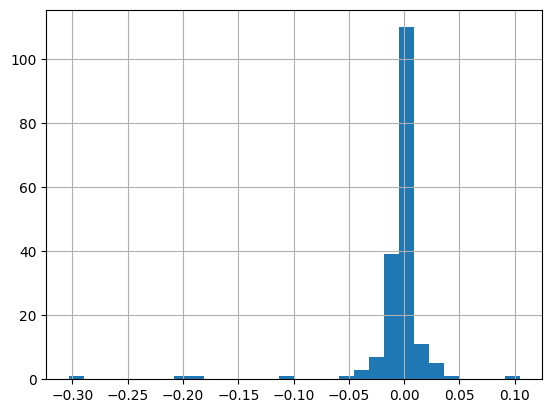

In [27]:
scores_diff.hist(bins=30)

In [37]:
robust_scores_diff = scores_diff[info_df.iloc[-1,2:] > 20]

<Axes: >

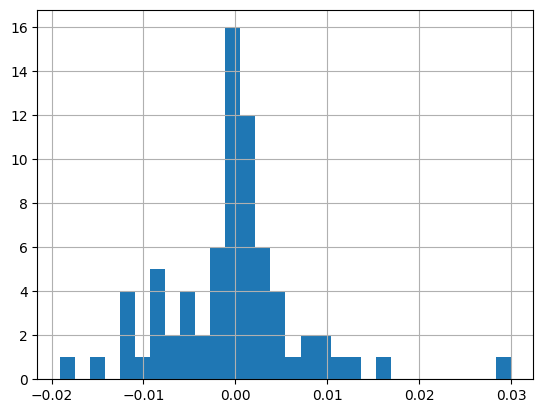

In [38]:
robust_scores_diff.hist(bins=30)

In [56]:
robust_scores_diff.sort_values(ascending=False).head(5).index

Index(['blhori1', 'greegr', 'rerswa1', 'categr', 'blnmon1'], dtype='object')